# **Python assignment**

In [4]:
# ---------------------------------------------------------
# File Name: MidTermAssignment.py
# Description: 
# Autor: Prat Paul; Gavini Charles; Fournier Justin; Blanc Mathieu
# Creation Date: 2024-10-16
# Version: 1.0
# ---------------------------------------------------------

Installing yahoofinance

In [5]:
#pip install yfinance

Installing statsmodels

In [6]:
#pip install statsmodels

In [7]:
#importations
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf # import this function from this submodule
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
import scipy.signal as ss
import pylab

# *First pandas dataframe of Amazon stocks*

In [8]:
# Importing Amazon stock from yahoo finance
Amazon = yf.download("AMZN", start="1999-01-21", end="2024-10-16")
Amazon.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037618,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041559,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038334,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038215,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038095,227520000


In [9]:
#pip install perfplot

In [10]:
latex_table = Amazon.head().to_latex(index=True)
with open("Latex/table.tex", "w") as file:
    file.write(latex_table)

/var/folders/5r/ft807c7n1ngd3fpt2_gwsg0m0000gn/T/ipykernel_56684/210123375.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = Amazon.head().to_latex(index=True)


# *Cheking if timestamp is 25 years*

In [11]:
print('Amazon data range is: ',Amazon.index[0],Amazon.index[-1])

#trying to find gaps

#First create a dataframe for a fullrange of our index, without any gap with the following formula: 
full_range = pd.date_range(start=Amazon.index.min(), end=Amazon.index.max(), freq='B')

#Then compare to our dataframe: 

MissingDays=full_range.difference(Amazon.index)

#Print the count and the detail preview:
print('Missing Days count is: ',len(MissingDays))
print("missing dates",MissingDays)

#We can see that data have ponctual gaps, no issue here we can still use it

Amazon data range is:  1999-01-22 00:00:00 2024-10-15 00:00:00
Missing Days count is:  238
missing dates DatetimeIndex(['1999-02-15', '1999-04-02', '1999-05-31', '1999-07-05',
               '1999-09-06', '1999-11-25', '1999-12-24', '2000-01-17',
               '2000-02-21', '2000-04-21',
               ...
               '2023-11-23', '2023-12-25', '2024-01-01', '2024-01-15',
               '2024-02-19', '2024-03-29', '2024-05-27', '2024-06-19',
               '2024-07-04', '2024-09-02'],
              dtype='datetime64[ns]', length=238, freq=None)


In [12]:
Amazon.index
#extracting adjusted
Nv_adj=Amazon['Adj Close']
Nv_adj.index = Amazon.index

#display first 5 rows, now it is a pandas series instead of a dataframe
Nv_adj.head()

Date
1999-01-22    0.037618
1999-01-25    0.041559
1999-01-26    0.038334
1999-01-27    0.038215
1999-01-28    0.038095
Name: Adj Close, dtype: float64

For the possible gaps in data, we plot them here

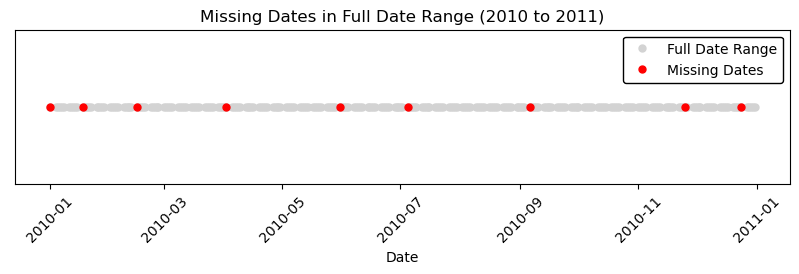

In [13]:
#plot the missing dates
full_data = Amazon.reindex(full_range)

#zoom in over one year
start_date = "2010-01-01"
end_date = "2011-01-01"
filtered_full_range = full_range[(full_range >= start_date) & (full_range <= end_date)]
filtered_missing_dates = MissingDays[(MissingDays >= start_date) & (MissingDays <= end_date)]

plt.figure(figsize=(10, 2))

# Plot all dates in the filtered range with gray dots (showing the full timeline for this period)
plt.plot(filtered_full_range, [1] * len(filtered_full_range), 'o', color='lightgray', markersize=5, label="Full Date Range")

# Overlay red dots only on the missing dates within the filtered range
plt.plot(filtered_missing_dates, [1] * len(filtered_missing_dates), 'ro', markersize=5, label="Missing Dates")

# Customize plot
plt.title("Missing Dates in Full Date Range (2010 to 2011)",color='black')
plt.xlabel("Date",color='black')
plt.yticks([])  # Hide y-axis labels for clarity
plt.xticks(rotation=45,color='black')
plt.legend(facecolor='white', edgecolor='black', framealpha=1, fontsize=10)

#Saving the plot in pdf format
plt.savefig('Latex/Img/MissingDates(2010_to_2011).pdf', format='pdf', bbox_inches='tight')

plt.show()


In [14]:
# extract the closing prices of the Amazon stok (as in lecture)
Pt_d_all = Amazon["Adj Close"]
Pt_d_all = Pt_d_all.rename('Pt.d')
# mutate the Index into a DatetimeIndex
Pt_d_all.index = pd.to_datetime(Pt_d_all.index)
Pt_d_all.head()

Date
1999-01-22    0.037618
1999-01-25    0.041559
1999-01-26    0.038334
1999-01-27    0.038215
1999-01-28    0.038095
Name: Pt.d, dtype: float64

Compute log price

In [15]:
pt_d_all = np.log(Pt_d_all)
pt_d_all = pt_d_all.rename('pt.d')
pt_d_all.head()

Date
1999-01-22   -3.280279
1999-01-25   -3.180647
1999-01-26   -3.261417
1999-01-27   -3.264532
1999-01-28   -3.267681
Name: pt.d, dtype: float64

Compute weekly monthly and yearly

In [16]:
pt_w_all = pt_d_all.resample('W').last()
pt_m_all = pt_d_all.resample('M').last()
pt_y_all = pt_d_all.resample('Y').last()
# and rename them:
pt_w_all = pt_w_all.rename('pt.w.all')
pt_m_all = pt_m_all.rename('pt.m.all')
pt_y_all = pt_y_all.rename('pt.y.all')

#idem for simply prices
Pt_w_all = Pt_d_all.resample('W').last()
Pt_m_all = Pt_d_all.resample('M').last()
Pt_y_all = Pt_d_all.resample('Y').last()
# and rename them:
Pt_w_all = Pt_w_all.rename('Pt_w_all')
Pt_m_all = Pt_m_all.rename('Pt_m_all')
Pt_y_all = Pt_y_all.rename('Pt_y_all')


Plot the simple prices

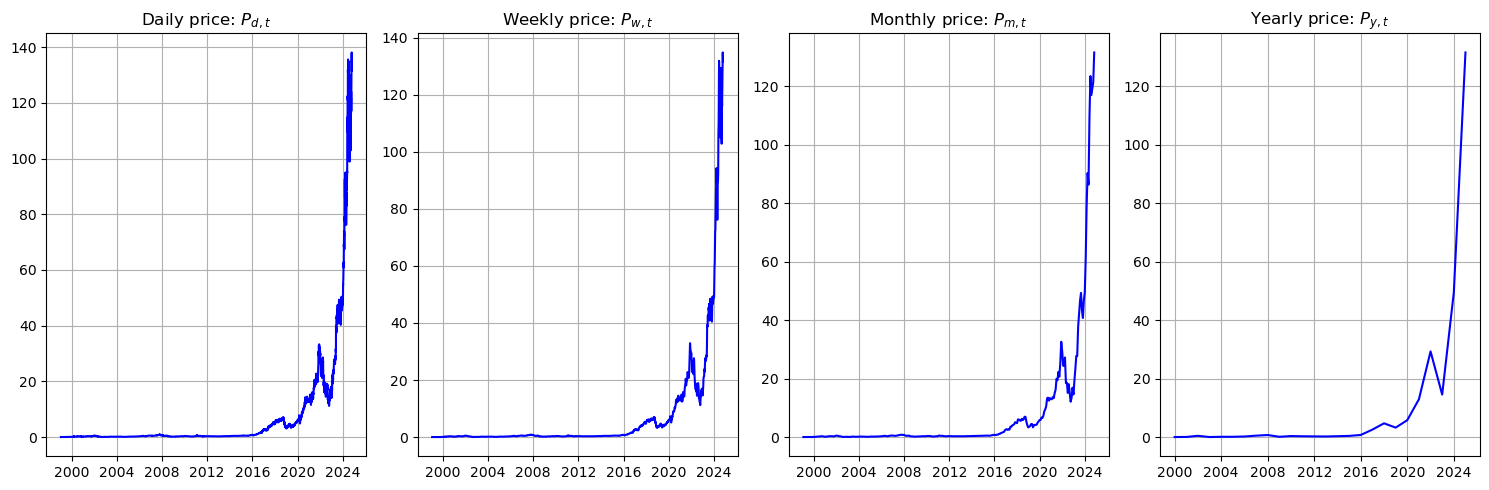

In [30]:
# set the 1x4 windows layout
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# Daily Price
axs[0].plot(Pt_d_all.index, Pt_d_all, color='blue')
axs[0].set_title('Daily price: $P_{d,t}$')
axs[0].grid(True)
# Weekly price
axs[1].plot(Pt_w_all.index, Pt_w_all, color='blue')
axs[1].set_title('Weekly price: $P_{w,t}$')
axs[1].grid(True)
# Monthly price
axs[2].plot(Pt_m_all.index, Pt_m_all, color='blue')
axs[2].set_title('Monthly price: $P_{m,t}$')
axs[2].grid(True)
#Yearly price
axs[3].plot(Pt_y_all.index, Pt_y_all, color='blue')
axs[3].set_title('Yearly price: $P_{y,t}$')
axs[3].grid(True)

# Manage margings and plot
plt.tight_layout()
plt.savefig('Latex/Img/prices_time.pdf', format='pdf', bbox_inches='tight')
plt.show()

Adding python code to the latex document in the appendix part

In [18]:
#Test for incorporating python code into the appendix section in the latex document
code_content = r"""
\section{Appendix: Python Code}
Below is the Python code used in this analysis.

\begin{lstlisting}[language=Python, caption=Python Code for Analysis]
# Python code example
import numpy as np
import pandas as pd

def analyze_data(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

data = [1, 2, 3, 4, 5]
mean, std_dev = analyze_data(data)
print(f"Mean: {mean}, Standard Deviation: {std_dev}")
\end{lstlisting}
"""

# Write to the 'code_appendix.tex' file
with open("Latex/code_appendix.tex", "w") as file:
    file.write(code_content)

# *Calculating returns*

In [19]:
#calculating return

#log returns

rt_d_all_temp = pt_d_all.diff()
rt_d_all_temp

Date
1999-01-22         NaN
1999-01-25    0.099632
1999-01-26   -0.080769
1999-01-27   -0.003115
1999-01-28   -0.003149
                ...   
2024-10-09   -0.001808
2024-10-10    0.016152
2024-10-11   -0.000074
2024-10-14    0.023969
2024-10-15   -0.047994
Name: pt.d, Length: 6475, dtype: float64

Compute daily, weekly, and monthly

In [ ]:
rt_d_all = pt_d_all.diff().dropna() #dropna remove the first NaN
rt_w_all = pt_w_all.diff().dropna()  
rt_m_all = pt_m_all.diff().dropna()     
rt_y_all = pt_y_all.diff().dropna()      

# and rename them: 
rt_d_all = rt_d_all.rename('rt_d_all')
rt_w_all = rt_w_all.rename('rt_w_all')
rt_m_all = rt_m_all.rename('rt_m_all')
rt_y_all = rt_y_all.rename('rt_y_all')
rt_d_all.head()

Date
1999-01-25    0.099632
1999-01-26   -0.080769
1999-01-27   -0.003115
1999-01-28   -0.003149
1999-01-29   -0.048161
Name: rt_d_all, dtype: float64

The first returns are correctly computed, we have to be careful to the dropna

Let's plot returns

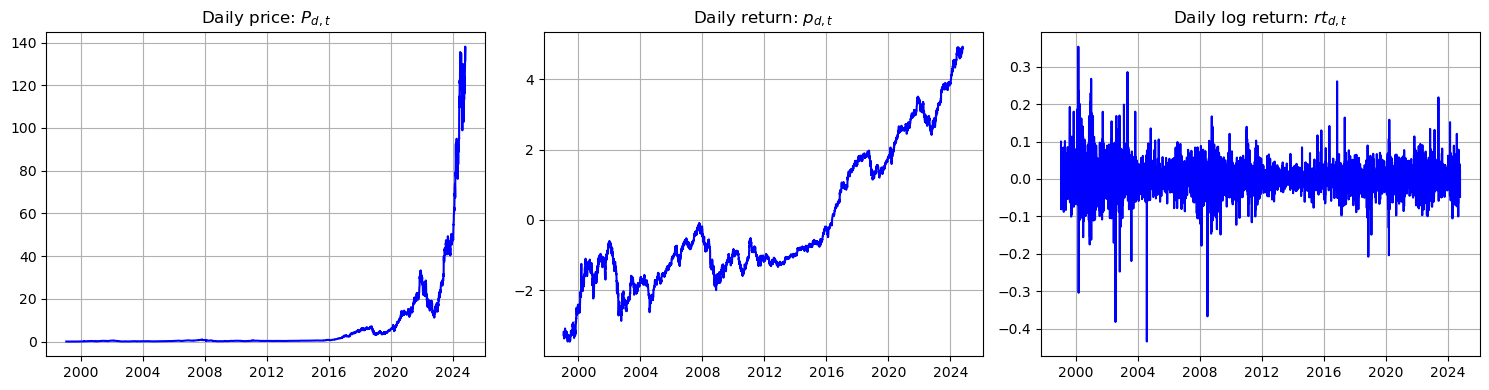

In [31]:
# set the 1x3 windows layout
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# Daily Price
axs[0].plot(Pt_d_all.index, Pt_d_all, color='blue')
axs[0].set_title('Daily price: $P_{d,t}$')
axs[0].grid(True)
# Daily log price
axs[1].plot(pt_d_all.index, pt_d_all, color='blue')
axs[1].set_title('Daily return: $p_{d,t}$')
axs[1].grid(True)
# Daily log returns
axs[2].plot(rt_d_all.index, rt_d_all, color='blue')
axs[2].set_title('Daily log return: $rt_{d,t}$')
axs[2].grid(True)


plt.tight_layout()
plt.savefig('Latex/Img/log_returns.pdf', format='pdf', bbox_inches='tight')
plt.show()

Squared returns

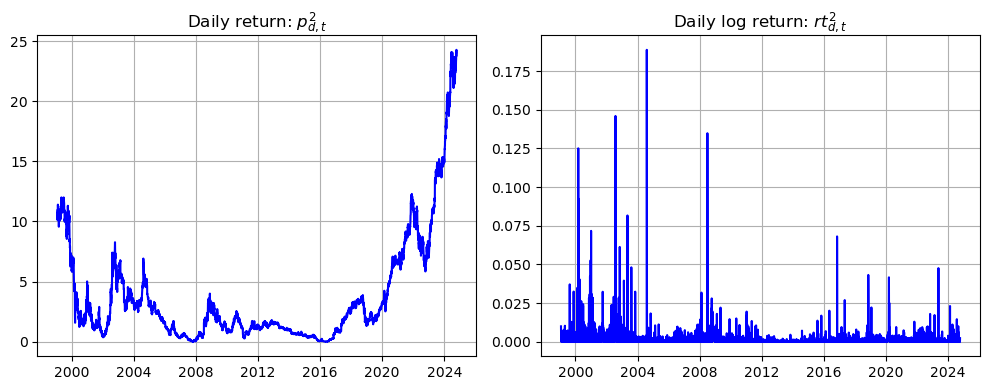

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Daily squared log price
axs[0].plot(pt_d_all.index, pt_d_all**2, color='blue')
axs[0].set_title('Daily return: $p_{d,t}^2$')
axs[0].grid(True)
# Daily squared log returns
axs[1].plot(rt_d_all.index, rt_d_all**2, color='blue')
axs[1].set_title('Daily log return: $rt_{d,t}^2$')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('Latex/Img/squared_log_returns.pdf', format='pdf', bbox_inches='tight')
plt.show()

# *Scatterplot of $p_{t} - p_{t-1}$*

First define the function for plotting a scatterplot

In [37]:
def lag1_scatterplot(data, x_label, y_label, title):
    plt.scatter(data.shift(), data, color='blue', s=30) #data.shift is just pt-1 (if t=0 what happend ?)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot([min(data), max(data)], [min(data), max(data)], linestyle='dashed', linewidth=2, color='red')

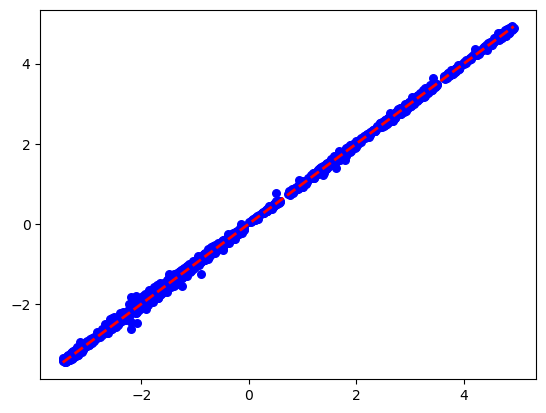

In [38]:
lag1_scatterplot(pt_d_all,"","","")

# Autocorrelation

In [42]:
autocorrelate=pt_d_all.shift().corr(pt_d_all, method='pearson')
print(round(autocorrelate,4))

0.9998


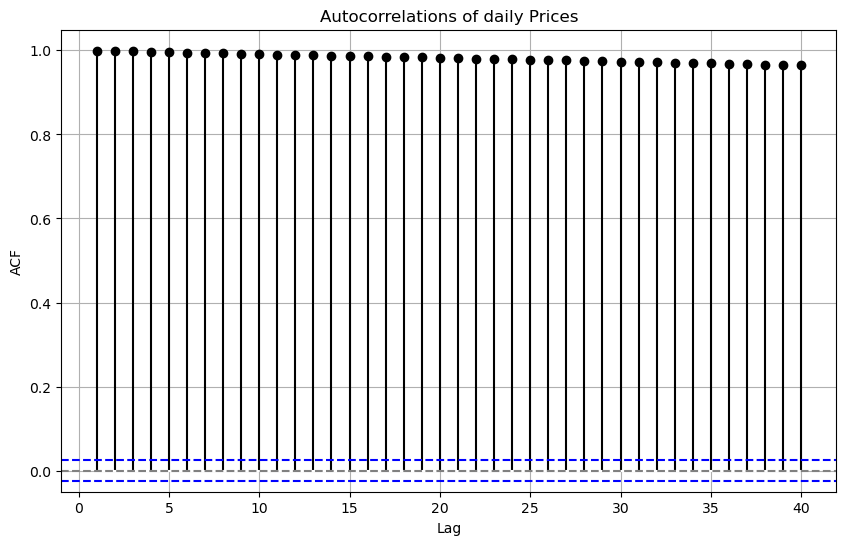

In [43]:
from statsmodels.tsa.stattools import acf

# Calculate empirical autocorrelation
lags = 40
acf_values = acf(pt_d_all, nlags=lags)

# Calculate Bartlett intervals
Bart_Int = 1.96 / np.sqrt(len(pt_d_all))

# Create the autocorrelation plot with Bartlett intervals
plt.figure(figsize=(10, 6))
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=Bart_Int, color='blue', linestyle='--')
plt.axhline(y=-Bart_Int, color='blue', linestyle='--')
plt.title('Autocorrelations of daily Prices')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()